In [22]:
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math
import hnswlib
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

In [23]:
from modules import network,mlp,contrastive_loss
from utils import yaml_config_hook,save_model

parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

# torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)
# torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
class_num = args.classnum

In [24]:
import scipy.sparse
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
high_var_gene = args.num_genes
# normlization and feature selection
adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
sc.pp.filter_genes(adataSC, min_cells=10)
adataSC.raw = adataSC
sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
sc.pp.normalize_total(adataSC, target_sum=1e4)
sc.pp.log1p(adataSC)

adataNorm = adataSC[:, adataSC.var.highly_variable]
dataframe = adataNorm.to_df()
x_ndarray = dataframe.values.squeeze()
y_ndarray = np.expand_dims(y, axis=1)
print(x_ndarray.shape,y_ndarray.shape)
dataframe.head()

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\anndata\_core\anndata.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_name in anno:


(8569, 2000) (8569, 1)


,2,10,13,41,45,62,68,106,133,147,...,19763,19786,19808,19854,19883,20021,20073,20109,20121,20124
0,0.0,1.302199,0.0,0.0,0.0,0.000000,0.36896,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.637877,0.368960
1,0.0,1.351171,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.888292,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.711146,0.00000,0.0,0.0,0.0,...,0.0,0.417500,0.0,0.0,0.93785,0.0,0.0,0.0,0.937850,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.509045,0.00000,0.0,0.0,0.0,...,0.0,0.509045,0.0,0.0,0.00000,0.0,0.0,0.0,0.509045,0.509045


In [25]:
from torch.utils.data import DataLoader,random_split,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32),
                              torch.tensor(y_ndarray, dtype=torch.float32))

scDataLoader = DataLoader(scDataset, shuffle=True, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

scGenDataLoader = DataLoader(scDataset, shuffle=False, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

2000
1024
1024
2000
1024
1024


In [26]:
# initialize model
mlpp = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlpp, args.feature_dim, args.classnum)
model = model.to('cuda')
# optimizer / loss
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

In [27]:
class StaticMemoryBank():

    def __init__(self,batch_size,x,y,dim):
        self.batch_size=batch_size
        self.dim=dim
        self.bank=hnswlib.Index(space='cosine',dim=dim)
        self.bank.init_index(max_elements=8569, ef_construction=100, M=16)
        self.bank.set_ef(100)
        self.bank.set_num_threads(4)
        self.bank.add_items(x)
        self.x_data=x
        self.y_data=y

    def generate_data(self,x_data,y_data):
        contrasts=np.zeros((self.batch_size,11,self.dim))
        # rare_list=[]
        for step,(x,y) in enumerate(zip(x_data,y_data)):
            if y in [8,10,11,13,14]:
                temp=np.tile(x, 10).reshape((10,2000))
                temp=np.row_stack((temp,x))
                # rare_list.append(step)
                contrasts[step]=temp
            else:
                labels,distances=self.bank.knn_query(x,k=10)
                temp=x_ndarray[labels.tolist()]
                temp=np.row_stack((temp,x))
                contrasts[step]=temp
        
        # return contrasts,rare_list
        return contrasts

In [28]:
def train(instance_loss,cluster_loss,memory_bank,model):
    loss_epoch=0
    for step,(data,label) in enumerate(scDataLoader):
        optimizer.zero_grad()
        
        embedding_data=data.numpy().copy()
        data=data.to('cuda')
        label=label.numpy().copy()
        
        contrast_samples=torch.tensor(memory_bank.generate_data(embedding_data,label),dtype=torch.float32)
        iter_times=10
        for index in range(1,11):
            x_i=contrast_samples[:,0].clone().to('cuda')
            # print(f'sample shape:\n{x_i.shape}')
            
            x_j=contrast_samples[:,index].to('cuda')
            # print(f'data shape:\n{x_j.shape}')

            z_i,z_j,c_i,c_j=model(x_i,x_j)
            loss_instance=instance_loss(z_i,z_j)
            loss_cluster=cluster_loss(c_i,c_j)
            loss = loss_instance + loss_cluster
            # print(f'------ loss:\n{loss}')
            loss.backward()
            optimizer.step()
            loss_epoch+=loss.item()
        if step % 2 == 0:
                print(f"Step [{step}/{len(scDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
            
    return loss_epoch/iter_times

In [29]:
def inference(loader, model, device):
    model.eval()
    feature_vector = []
    labels_vector = []
    for step, (x, y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            c = model.forward_cluster(x)
        c = c.detach()
        feature_vector.extend(c.cpu().detach().numpy())
        labels_vector.extend(y.numpy())
        if step % 1000 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")
    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    # print(feature_vector.shape, labels_vector.shape)
    return feature_vector, labels_vector

In [30]:
from evaluation import evaluation
def test():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X, Y = inference(scDataLoader, model, device)
    nmi, ari, f, acc = evaluation.evaluate(Y.reshape(-1), X)
    return nmi, ari, f, acc

In [31]:
loss_device=torch.device('cuda')
instance_loss=contrastive_loss.InstanceLoss(batch_size=args.batch_size,temperature=0.5,device=loss_device)
cluster_loss=contrastive_loss.ClusterLoss(class_num=class_num,temperature=0.5,device=loss_device)
accs=[]
losses=[]
aris=[]
nmis=[]
fs=[]

memory_bank=StaticMemoryBank(batch_size=args.batch_size,x=x_ndarray,y=y_ndarray,dim=2000)

for epoch in range(args.start_epoch, args.epochs+1):
    lr = optimizer.param_groups[0]["lr"]
    loss_epoch = train(instance_loss,cluster_loss,memory_bank,model=model)
    losses.append(loss_epoch/len(scDataLoader))
    if epoch % 1 == 0:
        save_model(args, model, optimizer, epoch)
    print(f"\nEpoch [{epoch}/{args.epochs}]\t Loss: {loss_epoch / len(scDataLoader)} \n")
    nmi, ari, f, acc = test()
    accs.append(acc)
    aris.append(ari)
    nmis.append(nmi)
    fs.append(f)
    print('Test NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    print('========'*8+'\n')

C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 7.603864669799805	 loss_cluster: 3.2981395721435547
Step [2/8]	 loss_instance: 7.3801445960998535	 loss_cluster: 3.297747850418091
Step [4/8]	 loss_instance: 7.079140663146973	 loss_cluster: 3.2954001426696777
Step [6/8]	 loss_instance: 6.977891445159912	 loss_cluster: 3.285017251968384

Epoch [1/200]	 Loss: 10.55862342119217 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4130 ARI = 0.2935 F = 0.4518 ACC = 0.0101



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.817903995513916	 loss_cluster: 3.259061813354492
Step [2/8]	 loss_instance: 6.675807476043701	 loss_cluster: 3.2163760662078857
Step [4/8]	 loss_instance: 6.602608680725098	 loss_cluster: 3.1517977714538574
Step [6/8]	 loss_instance: 6.558811187744141	 loss_cluster: 3.0678045749664307

Epoch [2/200]	 Loss: 9.888581573963165 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6254 ARI = 0.5842 F = 0.6746 ACC = 0.0051



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.502913475036621	 loss_cluster: 3.0031204223632812
Step [2/8]	 loss_instance: 6.456756114959717	 loss_cluster: 2.9349334239959717
Step [4/8]	 loss_instance: 6.430915355682373	 loss_cluster: 2.8588309288024902
Step [6/8]	 loss_instance: 6.406525611877441	 loss_cluster: 2.764359712600708

Epoch [3/200]	 Loss: 9.400861537456512 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6956 ARI = 0.6529 F = 0.7197 ACC = 0.0111



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.349363327026367	 loss_cluster: 2.6566452980041504
Step [2/8]	 loss_instance: 6.325876712799072	 loss_cluster: 2.548982858657837
Step [4/8]	 loss_instance: 6.2653608322143555	 loss_cluster: 2.4272828102111816
Step [6/8]	 loss_instance: 6.238827228546143	 loss_cluster: 2.368466377258301

Epoch [4/200]	 Loss: 8.864119660854339 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7217 ARI = 0.7136 F = 0.7682 ACC = 0.7405



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.237310409545898	 loss_cluster: 2.312870502471924
Step [2/8]	 loss_instance: 6.222329616546631	 loss_cluster: 2.2924039363861084
Step [4/8]	 loss_instance: 6.2027692794799805	 loss_cluster: 2.2403595447540283
Step [6/8]	 loss_instance: 6.206846714019775	 loss_cluster: 2.1878268718719482

Epoch [5/200]	 Loss: 8.563606452941894 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6951 ARI = 0.5161 F = 0.6113 ACC = 0.5720



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.1849541664123535	 loss_cluster: 2.1459920406341553
Step [2/8]	 loss_instance: 6.186471462249756	 loss_cluster: 2.122588634490967
Step [4/8]	 loss_instance: 6.171647548675537	 loss_cluster: 2.103724479675293
Step [6/8]	 loss_instance: 6.14381217956543	 loss_cluster: 2.032784938812256

Epoch [6/200]	 Loss: 8.385410344600677 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7251 ARI = 0.5502 F = 0.6420 ACC = 0.6198



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.157573699951172	 loss_cluster: 2.010568857192993
Step [2/8]	 loss_instance: 6.139366626739502	 loss_cluster: 2.005136489868164
Step [4/8]	 loss_instance: 6.124020576477051	 loss_cluster: 1.957650899887085
Step [6/8]	 loss_instance: 6.126905918121338	 loss_cluster: 1.937675952911377

Epoch [7/200]	 Loss: 8.240779721736908 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7043 ARI = 0.4832 F = 0.5845 ACC = 0.5471



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.1023712158203125	 loss_cluster: 1.9211499691009521
Step [2/8]	 loss_instance: 6.09462308883667	 loss_cluster: 1.8991981744766235
Step [4/8]	 loss_instance: 6.08817195892334	 loss_cluster: 1.8785301446914673
Step [6/8]	 loss_instance: 6.083142280578613	 loss_cluster: 1.8747024536132812

Epoch [8/200]	 Loss: 8.146288752555847 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7187 ARI = 0.5299 F = 0.6240 ACC = 0.5887



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.086777687072754	 loss_cluster: 1.848591923713684
Step [2/8]	 loss_instance: 6.075244903564453	 loss_cluster: 1.8504064083099365
Step [4/8]	 loss_instance: 6.088703632354736	 loss_cluster: 1.8413680791854858
Step [6/8]	 loss_instance: 6.0697526931762695	 loss_cluster: 1.8256912231445312

Epoch [9/200]	 Loss: 8.085618269443511 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7080 ARI = 0.4664 F = 0.5745 ACC = 0.5209



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0875959396362305	 loss_cluster: 1.8103013038635254
Step [2/8]	 loss_instance: 6.07275915145874	 loss_cluster: 1.8027851581573486
Step [4/8]	 loss_instance: 6.061997890472412	 loss_cluster: 1.808694839477539
Step [6/8]	 loss_instance: 6.074867248535156	 loss_cluster: 1.8446799516677856

Epoch [10/200]	 Loss: 8.05166090130806 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6822 ARI = 0.4500 F = 0.5572 ACC = 0.5438



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.042612075805664	 loss_cluster: 1.7841293811798096
Step [2/8]	 loss_instance: 6.055538654327393	 loss_cluster: 1.826615810394287
Step [4/8]	 loss_instance: 6.059961318969727	 loss_cluster: 1.832655429840088
Step [6/8]	 loss_instance: 6.059408664703369	 loss_cluster: 1.8446118831634521

Epoch [11/200]	 Loss: 8.071080911159516 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7159 ARI = 0.5199 F = 0.6172 ACC = 0.5654



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.051723003387451	 loss_cluster: 1.8057714700698853
Step [2/8]	 loss_instance: 6.035004615783691	 loss_cluster: 1.7776883840560913
Step [4/8]	 loss_instance: 6.023264408111572	 loss_cluster: 1.7502846717834473
Step [6/8]	 loss_instance: 6.037003517150879	 loss_cluster: 1.7670094966888428

Epoch [12/200]	 Loss: 8.00027643442154 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7139 ARI = 0.4700 F = 0.5800 ACC = 0.5037



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.027800559997559	 loss_cluster: 1.7457345724105835
Step [2/8]	 loss_instance: 6.035198211669922	 loss_cluster: 1.758019208908081
Step [4/8]	 loss_instance: 6.041934013366699	 loss_cluster: 1.7545511722564697
Step [6/8]	 loss_instance: 6.014976501464844	 loss_cluster: 1.7316431999206543

Epoch [13/200]	 Loss: 7.9476402461528775 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7121 ARI = 0.4553 F = 0.5683 ACC = 0.4883



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.018441200256348	 loss_cluster: 1.7465970516204834
Step [2/8]	 loss_instance: 6.001860618591309	 loss_cluster: 1.7214643955230713
Step [4/8]	 loss_instance: 6.007332801818848	 loss_cluster: 1.742965579032898
Step [6/8]	 loss_instance: 6.005404949188232	 loss_cluster: 1.7247273921966553

Epoch [14/200]	 Loss: 7.926265865564346 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7166 ARI = 0.4654 F = 0.5768 ACC = 0.5175



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.006040573120117	 loss_cluster: 1.705980658531189
Step [2/8]	 loss_instance: 6.006313323974609	 loss_cluster: 1.7406724691390991
Step [4/8]	 loss_instance: 6.020606517791748	 loss_cluster: 1.7657208442687988
Step [6/8]	 loss_instance: 6.019067764282227	 loss_cluster: 1.7809538841247559

Epoch [15/200]	 Loss: 7.93728352189064 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7200 ARI = 0.4643 F = 0.5752 ACC = 0.4902



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.000331878662109	 loss_cluster: 1.7448724508285522
Step [2/8]	 loss_instance: 5.993322849273682	 loss_cluster: 1.7222050428390503
Step [4/8]	 loss_instance: 5.990503311157227	 loss_cluster: 1.7041826248168945
Step [6/8]	 loss_instance: 6.001718997955322	 loss_cluster: 1.7102227210998535

Epoch [16/200]	 Loss: 7.904127967357636 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7173 ARI = 0.4452 F = 0.5601 ACC = 0.4656



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.00001859664917	 loss_cluster: 1.7120872735977173
Step [2/8]	 loss_instance: 5.985065460205078	 loss_cluster: 1.7055524587631226
Step [4/8]	 loss_instance: 5.9827728271484375	 loss_cluster: 1.7047621011734009
Step [6/8]	 loss_instance: 5.975750923156738	 loss_cluster: 1.6790591478347778

Epoch [17/200]	 Loss: 7.866535276174545 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7170 ARI = 0.4511 F = 0.5652 ACC = 0.4763



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.974648475646973	 loss_cluster: 1.6820610761642456
Step [2/8]	 loss_instance: 5.968456745147705	 loss_cluster: 1.6707324981689453
Step [4/8]	 loss_instance: 5.984939098358154	 loss_cluster: 1.7085667848587036
Step [6/8]	 loss_instance: 5.977785110473633	 loss_cluster: 1.6908727884292603

Epoch [18/200]	 Loss: 7.85905732512474 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7207 ARI = 0.4494 F = 0.5637 ACC = 0.4485



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.985673427581787	 loss_cluster: 1.6709778308868408
Step [2/8]	 loss_instance: 5.9639387130737305	 loss_cluster: 1.6553577184677124
Step [4/8]	 loss_instance: 5.987980365753174	 loss_cluster: 1.708095669746399
Step [6/8]	 loss_instance: 5.977411270141602	 loss_cluster: 1.6971105337142944

Epoch [19/200]	 Loss: 7.861217600107193 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7124 ARI = 0.4469 F = 0.5618 ACC = 0.4659



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9684157371521	 loss_cluster: 1.713781476020813
Step [2/8]	 loss_instance: 5.97304630279541	 loss_cluster: 1.6924993991851807
Step [4/8]	 loss_instance: 5.9674248695373535	 loss_cluster: 1.6777342557907104
Step [6/8]	 loss_instance: 5.974163055419922	 loss_cluster: 1.673444390296936

Epoch [20/200]	 Loss: 7.861899071931839 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7094 ARI = 0.4516 F = 0.5656 ACC = 0.5022



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.970903396606445	 loss_cluster: 1.6811461448669434
Step [2/8]	 loss_instance: 5.972348213195801	 loss_cluster: 1.6614596843719482
Step [4/8]	 loss_instance: 5.962676048278809	 loss_cluster: 1.6625300645828247
Step [6/8]	 loss_instance: 5.959099292755127	 loss_cluster: 1.6701985597610474

Epoch [21/200]	 Loss: 7.826404547691345 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7113 ARI = 0.4511 F = 0.5664 ACC = 0.4773



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.955740451812744	 loss_cluster: 1.6493942737579346
Step [2/8]	 loss_instance: 5.955835342407227	 loss_cluster: 1.658907175064087
Step [4/8]	 loss_instance: 5.96359920501709	 loss_cluster: 1.6622744798660278
Step [6/8]	 loss_instance: 5.962213039398193	 loss_cluster: 1.676236867904663

Epoch [22/200]	 Loss: 7.81809002161026 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7211 ARI = 0.4460 F = 0.5643 ACC = 0.4662



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.968941688537598	 loss_cluster: 1.6462193727493286
Step [2/8]	 loss_instance: 5.959654808044434	 loss_cluster: 1.641661286354065
Step [4/8]	 loss_instance: 5.961481094360352	 loss_cluster: 1.643601655960083
Step [6/8]	 loss_instance: 5.939657688140869	 loss_cluster: 1.620497703552246

Epoch [23/200]	 Loss: 7.791333204507827 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7250 ARI = 0.4502 F = 0.5684 ACC = 0.4697



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.943417549133301	 loss_cluster: 1.64425528049469
Step [2/8]	 loss_instance: 5.940218925476074	 loss_cluster: 1.620357871055603
Step [4/8]	 loss_instance: 5.954692363739014	 loss_cluster: 1.638870120048523
Step [6/8]	 loss_instance: 5.952093601226807	 loss_cluster: 1.6429184675216675

Epoch [24/200]	 Loss: 7.786124539375305 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7213 ARI = 0.4456 F = 0.5639 ACC = 0.4849



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.947572231292725	 loss_cluster: 1.6196932792663574
Step [2/8]	 loss_instance: 5.9408650398254395	 loss_cluster: 1.6257814168930054
Step [4/8]	 loss_instance: 5.947840690612793	 loss_cluster: 1.6212639808654785
Step [6/8]	 loss_instance: 5.944913387298584	 loss_cluster: 1.6232211589813232

Epoch [25/200]	 Loss: 7.768306243419647 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7283 ARI = 0.4486 F = 0.5675 ACC = 0.4691



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.938246726989746	 loss_cluster: 1.6087400913238525
Step [2/8]	 loss_instance: 5.942311763763428	 loss_cluster: 1.6328656673431396
Step [4/8]	 loss_instance: 5.941601276397705	 loss_cluster: 1.6063814163208008
Step [6/8]	 loss_instance: 5.947366714477539	 loss_cluster: 1.6059234142303467

Epoch [26/200]	 Loss: 7.7564924418926235 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7295 ARI = 0.4487 F = 0.5677 ACC = 0.4812



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.939047813415527	 loss_cluster: 1.60685396194458
Step [2/8]	 loss_instance: 5.952722549438477	 loss_cluster: 1.6213375329971313
Step [4/8]	 loss_instance: 5.936056613922119	 loss_cluster: 1.6069177389144897
Step [6/8]	 loss_instance: 5.940135955810547	 loss_cluster: 1.6179132461547852

Epoch [27/200]	 Loss: 7.753515267372132 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7310 ARI = 0.4521 F = 0.5708 ACC = 0.4540



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.934493541717529	 loss_cluster: 1.6009026765823364
Step [2/8]	 loss_instance: 5.941077709197998	 loss_cluster: 1.6268730163574219
Step [4/8]	 loss_instance: 5.949460506439209	 loss_cluster: 1.6303786039352417
Step [6/8]	 loss_instance: 5.927292823791504	 loss_cluster: 1.5990749597549438

Epoch [28/200]	 Loss: 7.751434957981109 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7330 ARI = 0.4535 F = 0.5720 ACC = 0.4624



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9439263343811035	 loss_cluster: 1.6161690950393677
Step [2/8]	 loss_instance: 5.9285407066345215	 loss_cluster: 1.5996190309524536
Step [4/8]	 loss_instance: 5.923788547515869	 loss_cluster: 1.5916181802749634
Step [6/8]	 loss_instance: 5.935636520385742	 loss_cluster: 1.6163465976715088

Epoch [29/200]	 Loss: 7.7305299758911135 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7316 ARI = 0.4508 F = 0.5697 ACC = 0.4825



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.934870719909668	 loss_cluster: 1.6031726598739624
Step [2/8]	 loss_instance: 5.928420543670654	 loss_cluster: 1.6155134439468384
Step [4/8]	 loss_instance: 5.92717170715332	 loss_cluster: 1.59597647190094
Step [6/8]	 loss_instance: 5.928061485290527	 loss_cluster: 1.6033438444137573

Epoch [30/200]	 Loss: 7.730379951000214 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7300 ARI = 0.4483 F = 0.5677 ACC = 0.4712



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.930994510650635	 loss_cluster: 1.6155753135681152
Step [2/8]	 loss_instance: 5.933882236480713	 loss_cluster: 1.613898754119873
Step [4/8]	 loss_instance: 5.924570083618164	 loss_cluster: 1.598315954208374
Step [6/8]	 loss_instance: 5.927114486694336	 loss_cluster: 1.5966600179672241

Epoch [31/200]	 Loss: 7.7295488059520725 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7326 ARI = 0.4513 F = 0.5698 ACC = 0.4736



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.936901092529297	 loss_cluster: 1.607155680656433
Step [2/8]	 loss_instance: 5.927005290985107	 loss_cluster: 1.602389931678772
Step [4/8]	 loss_instance: 5.933100700378418	 loss_cluster: 1.6160601377487183
Step [6/8]	 loss_instance: 5.917943954467773	 loss_cluster: 1.5953043699264526

Epoch [32/200]	 Loss: 7.718947160243988 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7328 ARI = 0.4558 F = 0.5735 ACC = 0.4884



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.917436122894287	 loss_cluster: 1.5936840772628784
Step [2/8]	 loss_instance: 5.920045375823975	 loss_cluster: 1.5918209552764893
Step [4/8]	 loss_instance: 5.921642780303955	 loss_cluster: 1.6041936874389648
Step [6/8]	 loss_instance: 5.927369594573975	 loss_cluster: 1.6029982566833496

Epoch [33/200]	 Loss: 7.723551046848297 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7307 ARI = 0.4525 F = 0.5707 ACC = 0.4773



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.918010711669922	 loss_cluster: 1.605958104133606
Step [2/8]	 loss_instance: 5.9283976554870605	 loss_cluster: 1.6126762628555298
Step [4/8]	 loss_instance: 5.9222869873046875	 loss_cluster: 1.6054996252059937
Step [6/8]	 loss_instance: 5.919952869415283	 loss_cluster: 1.5945950746536255

Epoch [34/200]	 Loss: 7.7199382245540615 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7268 ARI = 0.4491 F = 0.5672 ACC = 0.4799



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.92393684387207	 loss_cluster: 1.5939574241638184
Step [2/8]	 loss_instance: 5.917519569396973	 loss_cluster: 1.6033961772918701
Step [4/8]	 loss_instance: 5.929312229156494	 loss_cluster: 1.611143946647644
Step [6/8]	 loss_instance: 5.925911903381348	 loss_cluster: 1.6167033910751343

Epoch [35/200]	 Loss: 7.725402200222016 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7308 ARI = 0.4495 F = 0.5681 ACC = 0.4800



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.924481391906738	 loss_cluster: 1.6152704954147339
Step [2/8]	 loss_instance: 5.925145149230957	 loss_cluster: 1.6173757314682007
Step [4/8]	 loss_instance: 5.925416946411133	 loss_cluster: 1.6114673614501953
Step [6/8]	 loss_instance: 5.912139415740967	 loss_cluster: 1.5929996967315674

Epoch [36/200]	 Loss: 7.712031143903732 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7305 ARI = 0.4529 F = 0.5713 ACC = 0.4775



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.917620658874512	 loss_cluster: 1.599769115447998
Step [2/8]	 loss_instance: 5.916765213012695	 loss_cluster: 1.5893622636795044
Step [4/8]	 loss_instance: 5.911851406097412	 loss_cluster: 1.5919376611709595
Step [6/8]	 loss_instance: 5.922689437866211	 loss_cluster: 1.6045480966567993

Epoch [37/200]	 Loss: 7.70124181509018 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7295 ARI = 0.4471 F = 0.5665 ACC = 0.4709



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.906124114990234	 loss_cluster: 1.5837830305099487
Step [2/8]	 loss_instance: 5.918915271759033	 loss_cluster: 1.6054749488830566
Step [4/8]	 loss_instance: 5.910799980163574	 loss_cluster: 1.5901005268096924
Step [6/8]	 loss_instance: 5.90447473526001	 loss_cluster: 1.5879827737808228

Epoch [38/200]	 Loss: 7.697805589437484 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7335 ARI = 0.4523 F = 0.5707 ACC = 0.4686



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.905759334564209	 loss_cluster: 1.581681489944458
Step [2/8]	 loss_instance: 5.905512809753418	 loss_cluster: 1.5863986015319824
Step [4/8]	 loss_instance: 5.925240516662598	 loss_cluster: 1.6130660772323608
Step [6/8]	 loss_instance: 5.907482147216797	 loss_cluster: 1.587507963180542

Epoch [39/200]	 Loss: 7.692863684892655 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7257 ARI = 0.4459 F = 0.5647 ACC = 0.4722



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.904513359069824	 loss_cluster: 1.5928690433502197
Step [2/8]	 loss_instance: 5.910090446472168	 loss_cluster: 1.5942236185073853
Step [4/8]	 loss_instance: 5.903172969818115	 loss_cluster: 1.5769404172897339
Step [6/8]	 loss_instance: 5.907354354858398	 loss_cluster: 1.5852190256118774

Epoch [40/200]	 Loss: 7.691137588024139 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7325 ARI = 0.4505 F = 0.5690 ACC = 0.4658



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.906327724456787	 loss_cluster: 1.5871750116348267
Step [2/8]	 loss_instance: 5.9076361656188965	 loss_cluster: 1.5819028615951538
Step [4/8]	 loss_instance: 5.909368991851807	 loss_cluster: 1.586335301399231
Step [6/8]	 loss_instance: 5.910459995269775	 loss_cluster: 1.594504714012146

Epoch [41/200]	 Loss: 7.685958081483841 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7287 ARI = 0.4511 F = 0.5690 ACC = 0.4778



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.920013904571533	 loss_cluster: 1.5973912477493286
Step [2/8]	 loss_instance: 5.9132914543151855	 loss_cluster: 1.594504714012146
Step [4/8]	 loss_instance: 5.903447151184082	 loss_cluster: 1.5837297439575195
Step [6/8]	 loss_instance: 5.905515670776367	 loss_cluster: 1.572120189666748

Epoch [42/200]	 Loss: 7.689177757501602 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7292 ARI = 0.4469 F = 0.5661 ACC = 0.4689



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.913733005523682	 loss_cluster: 1.5927027463912964
Step [2/8]	 loss_instance: 5.90887975692749	 loss_cluster: 1.5826982259750366
Step [4/8]	 loss_instance: 5.907073497772217	 loss_cluster: 1.58156156539917
Step [6/8]	 loss_instance: 5.910214900970459	 loss_cluster: 1.5879350900650024

Epoch [43/200]	 Loss: 7.691306835412979 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7310 ARI = 0.4498 F = 0.5684 ACC = 0.4686



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.904126167297363	 loss_cluster: 1.588226556777954
Step [2/8]	 loss_instance: 5.907259941101074	 loss_cluster: 1.580114483833313
Step [4/8]	 loss_instance: 5.900712490081787	 loss_cluster: 1.5824933052062988
Step [6/8]	 loss_instance: 5.914083003997803	 loss_cluster: 1.6028763055801392

Epoch [44/200]	 Loss: 7.682009017467498 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7264 ARI = 0.4491 F = 0.5675 ACC = 0.4867



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.913898468017578	 loss_cluster: 1.594943881034851
Step [2/8]	 loss_instance: 5.9034881591796875	 loss_cluster: 1.5845577716827393
Step [4/8]	 loss_instance: 5.910802841186523	 loss_cluster: 1.5997651815414429
Step [6/8]	 loss_instance: 5.914839744567871	 loss_cluster: 1.6013438701629639

Epoch [45/200]	 Loss: 7.692097109556198 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7308 ARI = 0.4498 F = 0.5685 ACC = 0.4719



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.910040855407715	 loss_cluster: 1.5963146686553955
Step [2/8]	 loss_instance: 5.8995137214660645	 loss_cluster: 1.584668755531311
Step [4/8]	 loss_instance: 5.908076763153076	 loss_cluster: 1.5877543687820435
Step [6/8]	 loss_instance: 5.895909786224365	 loss_cluster: 1.5672041177749634

Epoch [46/200]	 Loss: 7.679229760169983 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7339 ARI = 0.4524 F = 0.5706 ACC = 0.4677



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.905277729034424	 loss_cluster: 1.5940399169921875
Step [2/8]	 loss_instance: 5.915798664093018	 loss_cluster: 1.5990464687347412
Step [4/8]	 loss_instance: 5.899929046630859	 loss_cluster: 1.5779985189437866
Step [6/8]	 loss_instance: 5.897542476654053	 loss_cluster: 1.5732386112213135

Epoch [47/200]	 Loss: 7.673168969154358 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7275 ARI = 0.4453 F = 0.5642 ACC = 0.4666



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.899168491363525	 loss_cluster: 1.5717617273330688
Step [2/8]	 loss_instance: 5.906412601470947	 loss_cluster: 1.5969915390014648
Step [4/8]	 loss_instance: 5.9009175300598145	 loss_cluster: 1.5882161855697632
Step [6/8]	 loss_instance: 5.9089202880859375	 loss_cluster: 1.5902177095413208

Epoch [48/200]	 Loss: 7.678221356868744 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7247 ARI = 0.4434 F = 0.5617 ACC = 0.4844



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.906228542327881	 loss_cluster: 1.5854719877243042
Step [2/8]	 loss_instance: 5.915812015533447	 loss_cluster: 1.5923473834991455
Step [4/8]	 loss_instance: 5.90017032623291	 loss_cluster: 1.5826951265335083
Step [6/8]	 loss_instance: 5.906768798828125	 loss_cluster: 1.5845434665679932

Epoch [49/200]	 Loss: 7.676790052652359 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7300 ARI = 0.4502 F = 0.5682 ACC = 0.4766



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.90087890625	 loss_cluster: 1.5744142532348633
Step [2/8]	 loss_instance: 5.901755332946777	 loss_cluster: 1.5813558101654053
Step [4/8]	 loss_instance: 5.900109767913818	 loss_cluster: 1.592676043510437
Step [6/8]	 loss_instance: 5.896946430206299	 loss_cluster: 1.5857852697372437

Epoch [50/200]	 Loss: 7.668245667219162 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7262 ARI = 0.4453 F = 0.5634 ACC = 0.4843



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.898509979248047	 loss_cluster: 1.5742807388305664
Step [2/8]	 loss_instance: 5.897914886474609	 loss_cluster: 1.5741007328033447
Step [4/8]	 loss_instance: 5.9019646644592285	 loss_cluster: 1.5837255716323853
Step [6/8]	 loss_instance: 5.900077819824219	 loss_cluster: 1.5940335988998413

Epoch [51/200]	 Loss: 7.669376820325851 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7296 ARI = 0.4500 F = 0.5685 ACC = 0.4814



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8954010009765625	 loss_cluster: 1.5801442861557007
Step [2/8]	 loss_instance: 5.901470184326172	 loss_cluster: 1.5882939100265503
Step [4/8]	 loss_instance: 5.901517391204834	 loss_cluster: 1.5788055658340454
Step [6/8]	 loss_instance: 5.900081634521484	 loss_cluster: 1.5848667621612549

Epoch [52/200]	 Loss: 7.6624348819255825 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7320 ARI = 0.4519 F = 0.5702 ACC = 0.4711



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.894663333892822	 loss_cluster: 1.5777703523635864
Step [2/8]	 loss_instance: 5.9029364585876465	 loss_cluster: 1.5833879709243774
Step [4/8]	 loss_instance: 5.900030136108398	 loss_cluster: 1.578836441040039
Step [6/8]	 loss_instance: 5.900948524475098	 loss_cluster: 1.5838203430175781

Epoch [53/200]	 Loss: 7.662987899780274 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7302 ARI = 0.4489 F = 0.5675 ACC = 0.4762



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.896378517150879	 loss_cluster: 1.576165795326233
Step [2/8]	 loss_instance: 5.903324604034424	 loss_cluster: 1.5966905355453491
Step [4/8]	 loss_instance: 5.9001617431640625	 loss_cluster: 1.5774983167648315
Step [6/8]	 loss_instance: 5.901183605194092	 loss_cluster: 1.5880810022354126

Epoch [54/200]	 Loss: 7.666475874185562 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7272 ARI = 0.4441 F = 0.5638 ACC = 0.4662



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.907039165496826	 loss_cluster: 1.5804784297943115
Step [2/8]	 loss_instance: 5.901287078857422	 loss_cluster: 1.5914291143417358
Step [4/8]	 loss_instance: 5.897075176239014	 loss_cluster: 1.5899771451950073
Step [6/8]	 loss_instance: 5.895057678222656	 loss_cluster: 1.574759840965271

Epoch [55/200]	 Loss: 7.66692202091217 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7249 ARI = 0.4426 F = 0.5619 ACC = 0.4739



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.897712230682373	 loss_cluster: 1.5766966342926025
Step [2/8]	 loss_instance: 5.896244049072266	 loss_cluster: 1.571674108505249
Step [4/8]	 loss_instance: 5.8977789878845215	 loss_cluster: 1.581447720527649
Step [6/8]	 loss_instance: 5.898130416870117	 loss_cluster: 1.5792025327682495

Epoch [56/200]	 Loss: 7.657174777984619 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7286 ARI = 0.4521 F = 0.5698 ACC = 0.4883



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.891762733459473	 loss_cluster: 1.5727856159210205
Step [2/8]	 loss_instance: 5.910329818725586	 loss_cluster: 1.5933868885040283
Step [4/8]	 loss_instance: 5.903674602508545	 loss_cluster: 1.579322338104248
Step [6/8]	 loss_instance: 5.902758598327637	 loss_cluster: 1.5809407234191895

Epoch [57/200]	 Loss: 7.659128201007843 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7246 ARI = 0.4401 F = 0.5593 ACC = 0.4707



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.898721694946289	 loss_cluster: 1.5780147314071655
Step [2/8]	 loss_instance: 5.890254974365234	 loss_cluster: 1.5762492418289185
Step [4/8]	 loss_instance: 5.887789726257324	 loss_cluster: 1.5735670328140259
Step [6/8]	 loss_instance: 5.899216175079346	 loss_cluster: 1.57804274559021

Epoch [58/200]	 Loss: 7.654835957288742 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7221 ARI = 0.4382 F = 0.5574 ACC = 0.4729



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.883192539215088	 loss_cluster: 1.5681116580963135
Step [2/8]	 loss_instance: 5.8859734535217285	 loss_cluster: 1.5654886960983276
Step [4/8]	 loss_instance: 5.89377498626709	 loss_cluster: 1.570565938949585
Step [6/8]	 loss_instance: 5.9010138511657715	 loss_cluster: 1.5802044868469238

Epoch [59/200]	 Loss: 7.653648781776428 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7215 ARI = 0.4423 F = 0.5613 ACC = 0.4753



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.894768238067627	 loss_cluster: 1.5810234546661377
Step [2/8]	 loss_instance: 5.8981852531433105	 loss_cluster: 1.5716021060943604
Step [4/8]	 loss_instance: 5.891120910644531	 loss_cluster: 1.5906480550765991
Step [6/8]	 loss_instance: 5.903019428253174	 loss_cluster: 1.5800774097442627

Epoch [60/200]	 Loss: 7.660878294706345 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7264 ARI = 0.4448 F = 0.5631 ACC = 0.4672



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.898813247680664	 loss_cluster: 1.5959051847457886
Step [2/8]	 loss_instance: 5.898224353790283	 loss_cluster: 1.5821876525878906
Step [4/8]	 loss_instance: 5.886605262756348	 loss_cluster: 1.570043683052063
Step [6/8]	 loss_instance: 5.897104263305664	 loss_cluster: 1.5843325853347778

Epoch [61/200]	 Loss: 7.657615822553635 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7174 ARI = 0.4328 F = 0.5513 ACC = 0.4741



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.902646541595459	 loss_cluster: 1.5767625570297241
Step [2/8]	 loss_instance: 5.894026279449463	 loss_cluster: 1.5786405801773071
Step [4/8]	 loss_instance: 5.885782718658447	 loss_cluster: 1.5690144300460815
Step [6/8]	 loss_instance: 5.886985778808594	 loss_cluster: 1.5740028619766235

Epoch [62/200]	 Loss: 7.652021789550782 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7282 ARI = 0.4489 F = 0.5668 ACC = 0.4777



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.890199184417725	 loss_cluster: 1.5637624263763428
Step [2/8]	 loss_instance: 5.897408485412598	 loss_cluster: 1.5847759246826172
Step [4/8]	 loss_instance: 5.896361827850342	 loss_cluster: 1.5820066928863525
Step [6/8]	 loss_instance: 5.89021635055542	 loss_cluster: 1.5756081342697144

Epoch [63/200]	 Loss: 7.649442762136459 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7235 ARI = 0.4405 F = 0.5596 ACC = 0.4700



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.88690185546875	 loss_cluster: 1.5687958002090454
Step [2/8]	 loss_instance: 5.892706394195557	 loss_cluster: 1.5753716230392456
Step [4/8]	 loss_instance: 5.888363838195801	 loss_cluster: 1.572975516319275
Step [6/8]	 loss_instance: 5.891890525817871	 loss_cluster: 1.5725022554397583

Epoch [64/200]	 Loss: 7.643691730499268 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7273 ARI = 0.4475 F = 0.5654 ACC = 0.4767



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.886082172393799	 loss_cluster: 1.5625475645065308
Step [2/8]	 loss_instance: 5.900721073150635	 loss_cluster: 1.5856355428695679
Step [4/8]	 loss_instance: 5.885382652282715	 loss_cluster: 1.5692113637924194
Step [6/8]	 loss_instance: 5.897764205932617	 loss_cluster: 1.5906665325164795

Epoch [65/200]	 Loss: 7.649559289216995 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7273 ARI = 0.4496 F = 0.5673 ACC = 0.4885



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.894357681274414	 loss_cluster: 1.5740337371826172
Step [2/8]	 loss_instance: 5.902939319610596	 loss_cluster: 1.5797359943389893
Step [4/8]	 loss_instance: 5.896744251251221	 loss_cluster: 1.578933835029602
Step [6/8]	 loss_instance: 5.899363994598389	 loss_cluster: 1.5887295007705688

Epoch [66/200]	 Loss: 7.658718061447144 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7195 ARI = 0.4321 F = 0.5517 ACC = 0.4806



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.896857261657715	 loss_cluster: 1.5778846740722656
Step [2/8]	 loss_instance: 5.887874603271484	 loss_cluster: 1.5697088241577148
Step [4/8]	 loss_instance: 5.892751693725586	 loss_cluster: 1.5750640630722046
Step [6/8]	 loss_instance: 5.898987293243408	 loss_cluster: 1.5838743448257446

Epoch [67/200]	 Loss: 7.655450922250748 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7218 ARI = 0.4361 F = 0.5551 ACC = 0.4677



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.890429496765137	 loss_cluster: 1.5648466348648071
Step [2/8]	 loss_instance: 5.888319492340088	 loss_cluster: 1.5689059495925903
Step [4/8]	 loss_instance: 5.891643524169922	 loss_cluster: 1.5748869180679321
Step [6/8]	 loss_instance: 5.905074596405029	 loss_cluster: 1.589777946472168

Epoch [68/200]	 Loss: 7.642939907312393 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7228 ARI = 0.4349 F = 0.5545 ACC = 0.4781



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.887017250061035	 loss_cluster: 1.5670876502990723
Step [2/8]	 loss_instance: 5.889737606048584	 loss_cluster: 1.581149935722351
Step [4/8]	 loss_instance: 5.890171051025391	 loss_cluster: 1.570514440536499
Step [6/8]	 loss_instance: 5.882038116455078	 loss_cluster: 1.5704184770584106

Epoch [69/200]	 Loss: 7.641800725460053 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7147 ARI = 0.4227 F = 0.5430 ACC = 0.4750



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.889951705932617	 loss_cluster: 1.576177716255188
Step [2/8]	 loss_instance: 5.889440059661865	 loss_cluster: 1.5822938680648804
Step [4/8]	 loss_instance: 5.887512683868408	 loss_cluster: 1.5736559629440308
Step [6/8]	 loss_instance: 5.888763427734375	 loss_cluster: 1.569858193397522

Epoch [70/200]	 Loss: 7.639550578594208 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7207 ARI = 0.4366 F = 0.5558 ACC = 0.4720



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_14708\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.881872177124023	 loss_cluster: 1.5650173425674438


KeyboardInterrupt: 

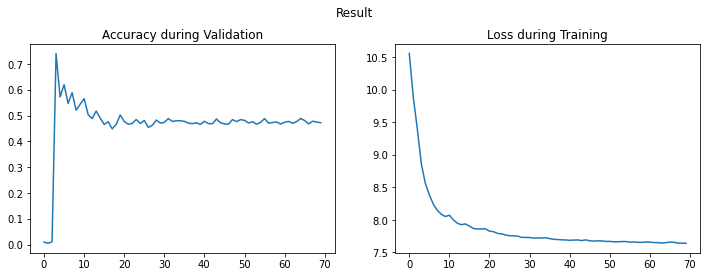

In [33]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(accs)
ax[0].set_title('Accuracy during Validation')
ax[1].plot(losses)
ax[1].set_title('Loss during Training')

plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()

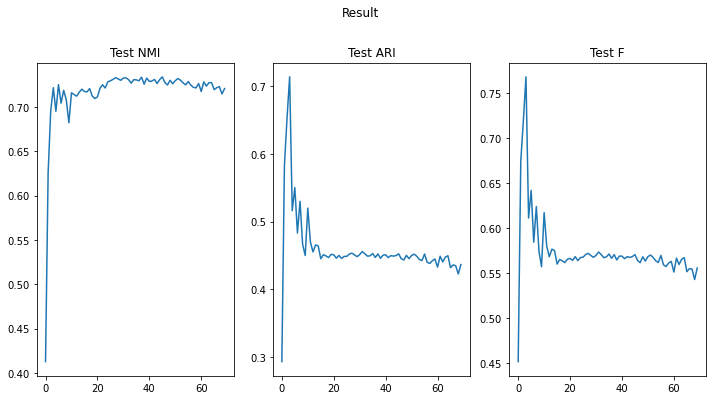

In [34]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
ax[0].plot(nmis)
ax[0].set_title('Test NMI')
ax[1].plot(aris)
ax[1].set_title('Test ARI')
ax[2].plot(fs)
ax[2].set_title('Test F')


plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

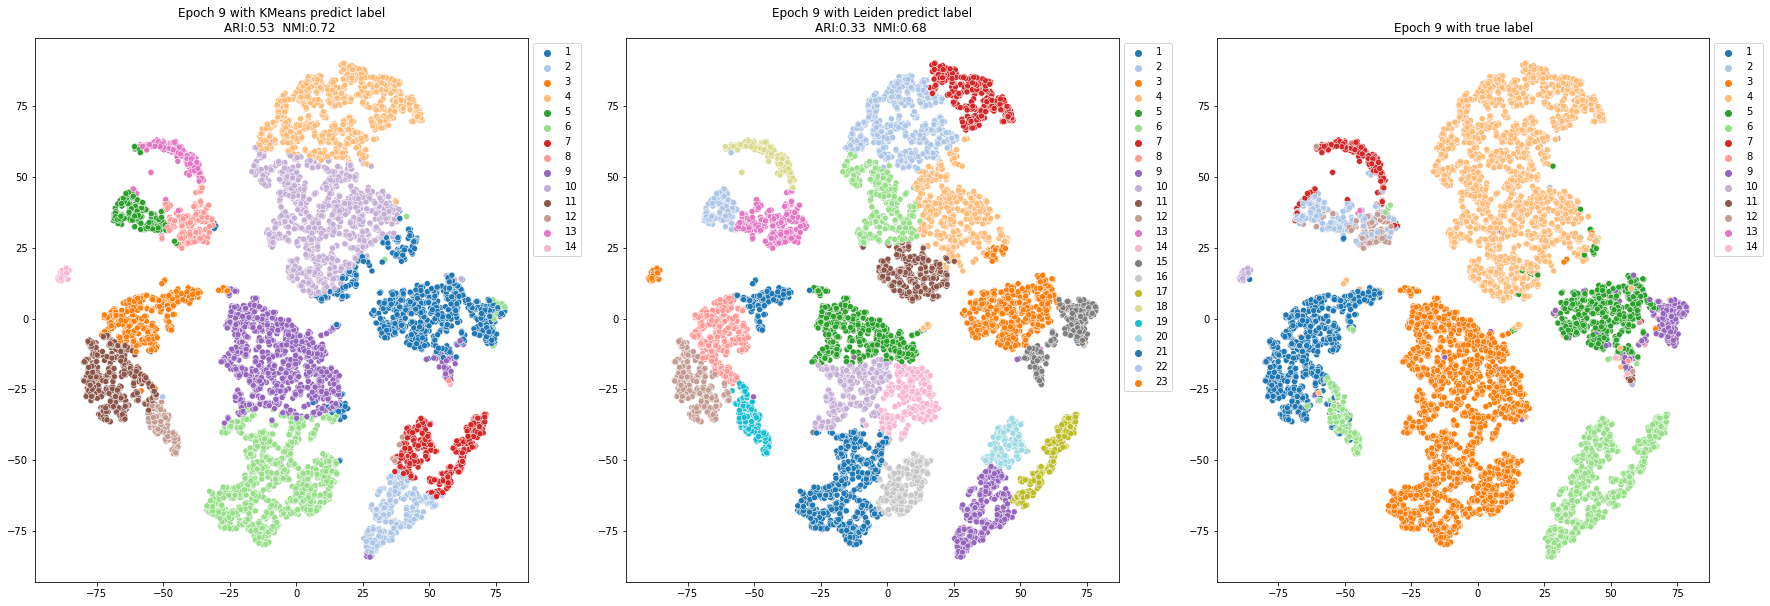

In [37]:
from evaluation import evaluation_tools
from sklearn.manifold import TSNE

mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim, args.classnum)
model = model.to('cuda')

checkpoint = torch.load('save\sc-static-bank\checkpoint_9.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=9)

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

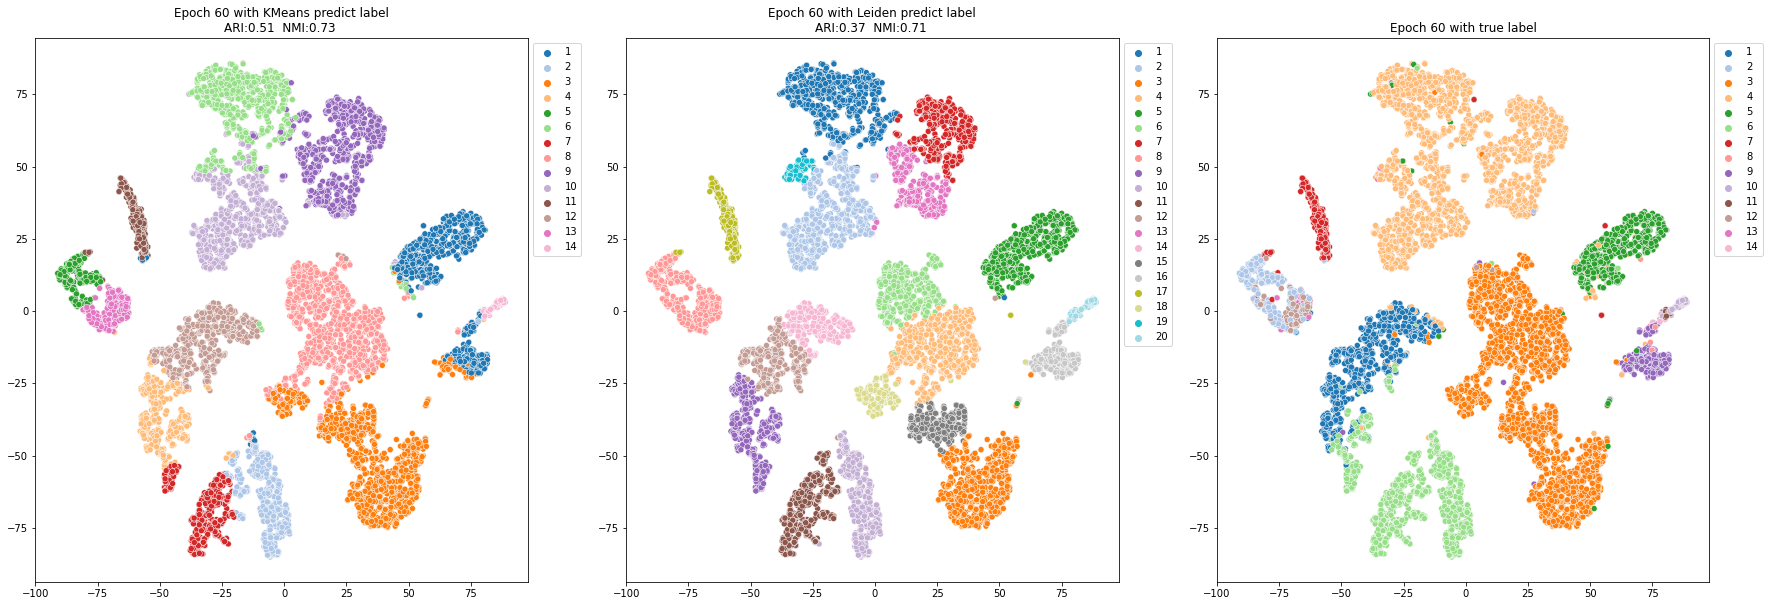

In [38]:
checkpoint = torch.load('save\sc-static-bank\checkpoint_60.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=60)